# Import

In [2]:
from pathlib import Path
import torch
import numpy as np
import os
from pathlib import Path
import sys
import numpy as np 
from datasets import load_dataset
import tqdm
import torch
parent_root = Path.cwd().parent
project_root = os.path.join(parent_root, "src")
sys.path.insert(0, str(project_root))
from pytorch_lightning import seed_everything
from accelerate import Accelerator
import matplotlib.pyplot as plt
import hydra
import evaluate
from datasets import load_from_disk

from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize_config_dir
from omegaconf import DictConfig, OmegaConf
from hydra import compose, initialize

from datamodule import DataModule_multi
from lightning_module import multimodal_pl
from transformers import BlipForConditionalGeneration, get_linear_schedule_with_warmup, AutoProcessor




/home/clement/mnt/ssd_nvme/ai-med-portfolio/projects/dl/multimodal/multimodal-med-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
out_dir = Path("..") / "src"
data_dir = Path("..") / "data"

# Def datamodule / model

In [4]:
@hydra.main(config_path="config", config_name="config_seg", version_base="1.3")
def main(cfg: DictConfig):

    seed_everything(cfg.get("seed", 42), workers=True)

    cfg_data = cfg.data
    cfg_model = cfg.model

    datamodule = DataModule_multi(cfg_data)
    model = multimodal_pl(cfg_model)
    return model, datamodule, cfg_data


GlobalHydra.instance().clear()
config_path = os.path.join(out_dir, "config")

with initialize(version_base=None, config_path=config_path, job_name="nb"):
    cfg = compose(config_name="config")
    model, datamodule, cfg_data = main(cfg)
    

Seed set to 42


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model token id 0


In [5]:
datamodule.setup(stage="test")
test_loader = datamodule.test_dataloader()



In [6]:
ckpt_path = Path("..") / "checkpoints/best.ckpt"
model = multimodal_pl.load_from_checkpoint(
    ckpt_path,
    weights_only = False
)

model token id 0


In [7]:
accelerator = Accelerator(mixed_precision="bf16")
model = accelerator.prepare(
    model
)

model.eval()

multimodal_pl(
  (model): BlipForConditionalGeneration(
    (vision_model): BlipVisionModel(
      (embeddings): BlipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (encoder): BlipEncoder(
        (layers): ModuleList(
          (0-11): 12 x BlipEncoderLayer(
            (self_attn): BlipAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (projection): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): BlipMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=True)
            )
            (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        

# test model

In [8]:
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

total_loss = 0.0
total_tokens = 0
test_preds = []
test_refs = []
rouge = evaluate.load("rouge")
batch_idx = 0
with torch.no_grad():
    for batch in tqdm.tqdm(test_loader, desc="Test loss"):
        batch = {k: v.to(device) for k, v in batch.items()}

        out = model(
            pixel_values = batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        loss = out.loss  

        n_tokens = (batch["labels"] != -100).sum().item()

        total_loss += loss.item() * n_tokens
        total_tokens += n_tokens
        
        if batch_idx%8 == 0:
            gen_ids = model.model.generate(
                pixel_values = batch["pixel_values"],
                max_new_tokens = 64,
                num_beams = 3,
            )
            preds = model.processor.tokenizer.batch_decode(gen_ids, skip_special_tokens = True)
            refs = model.processor.tokenizer.batch_decode(batch["input_ids"], skip_special_tokens = True)
            test_preds.extend([p.strip() for p in preds])
            test_refs.extend([r.strip() for r in refs])
            
        batch_idx += 1
            
avg_loss = total_loss / max(total_tokens, 1)
scores = rouge.compute(
        predictions = test_preds,
        references = test_refs,
        rouge_types = ["rougeL"],
    )
rouge_l = scores["rougeL"]
print({"test_loss": avg_loss, "n_tokens": total_tokens, "rouge_l": rouge_l})


Test loss: 100%|██████████| 1241/1241 [01:49<00:00, 11.36it/s]

{'test_loss': 2.6245189622140255, 'n_tokens': 376999, 'rouge_l': np.float64(0.1965957958817312)}


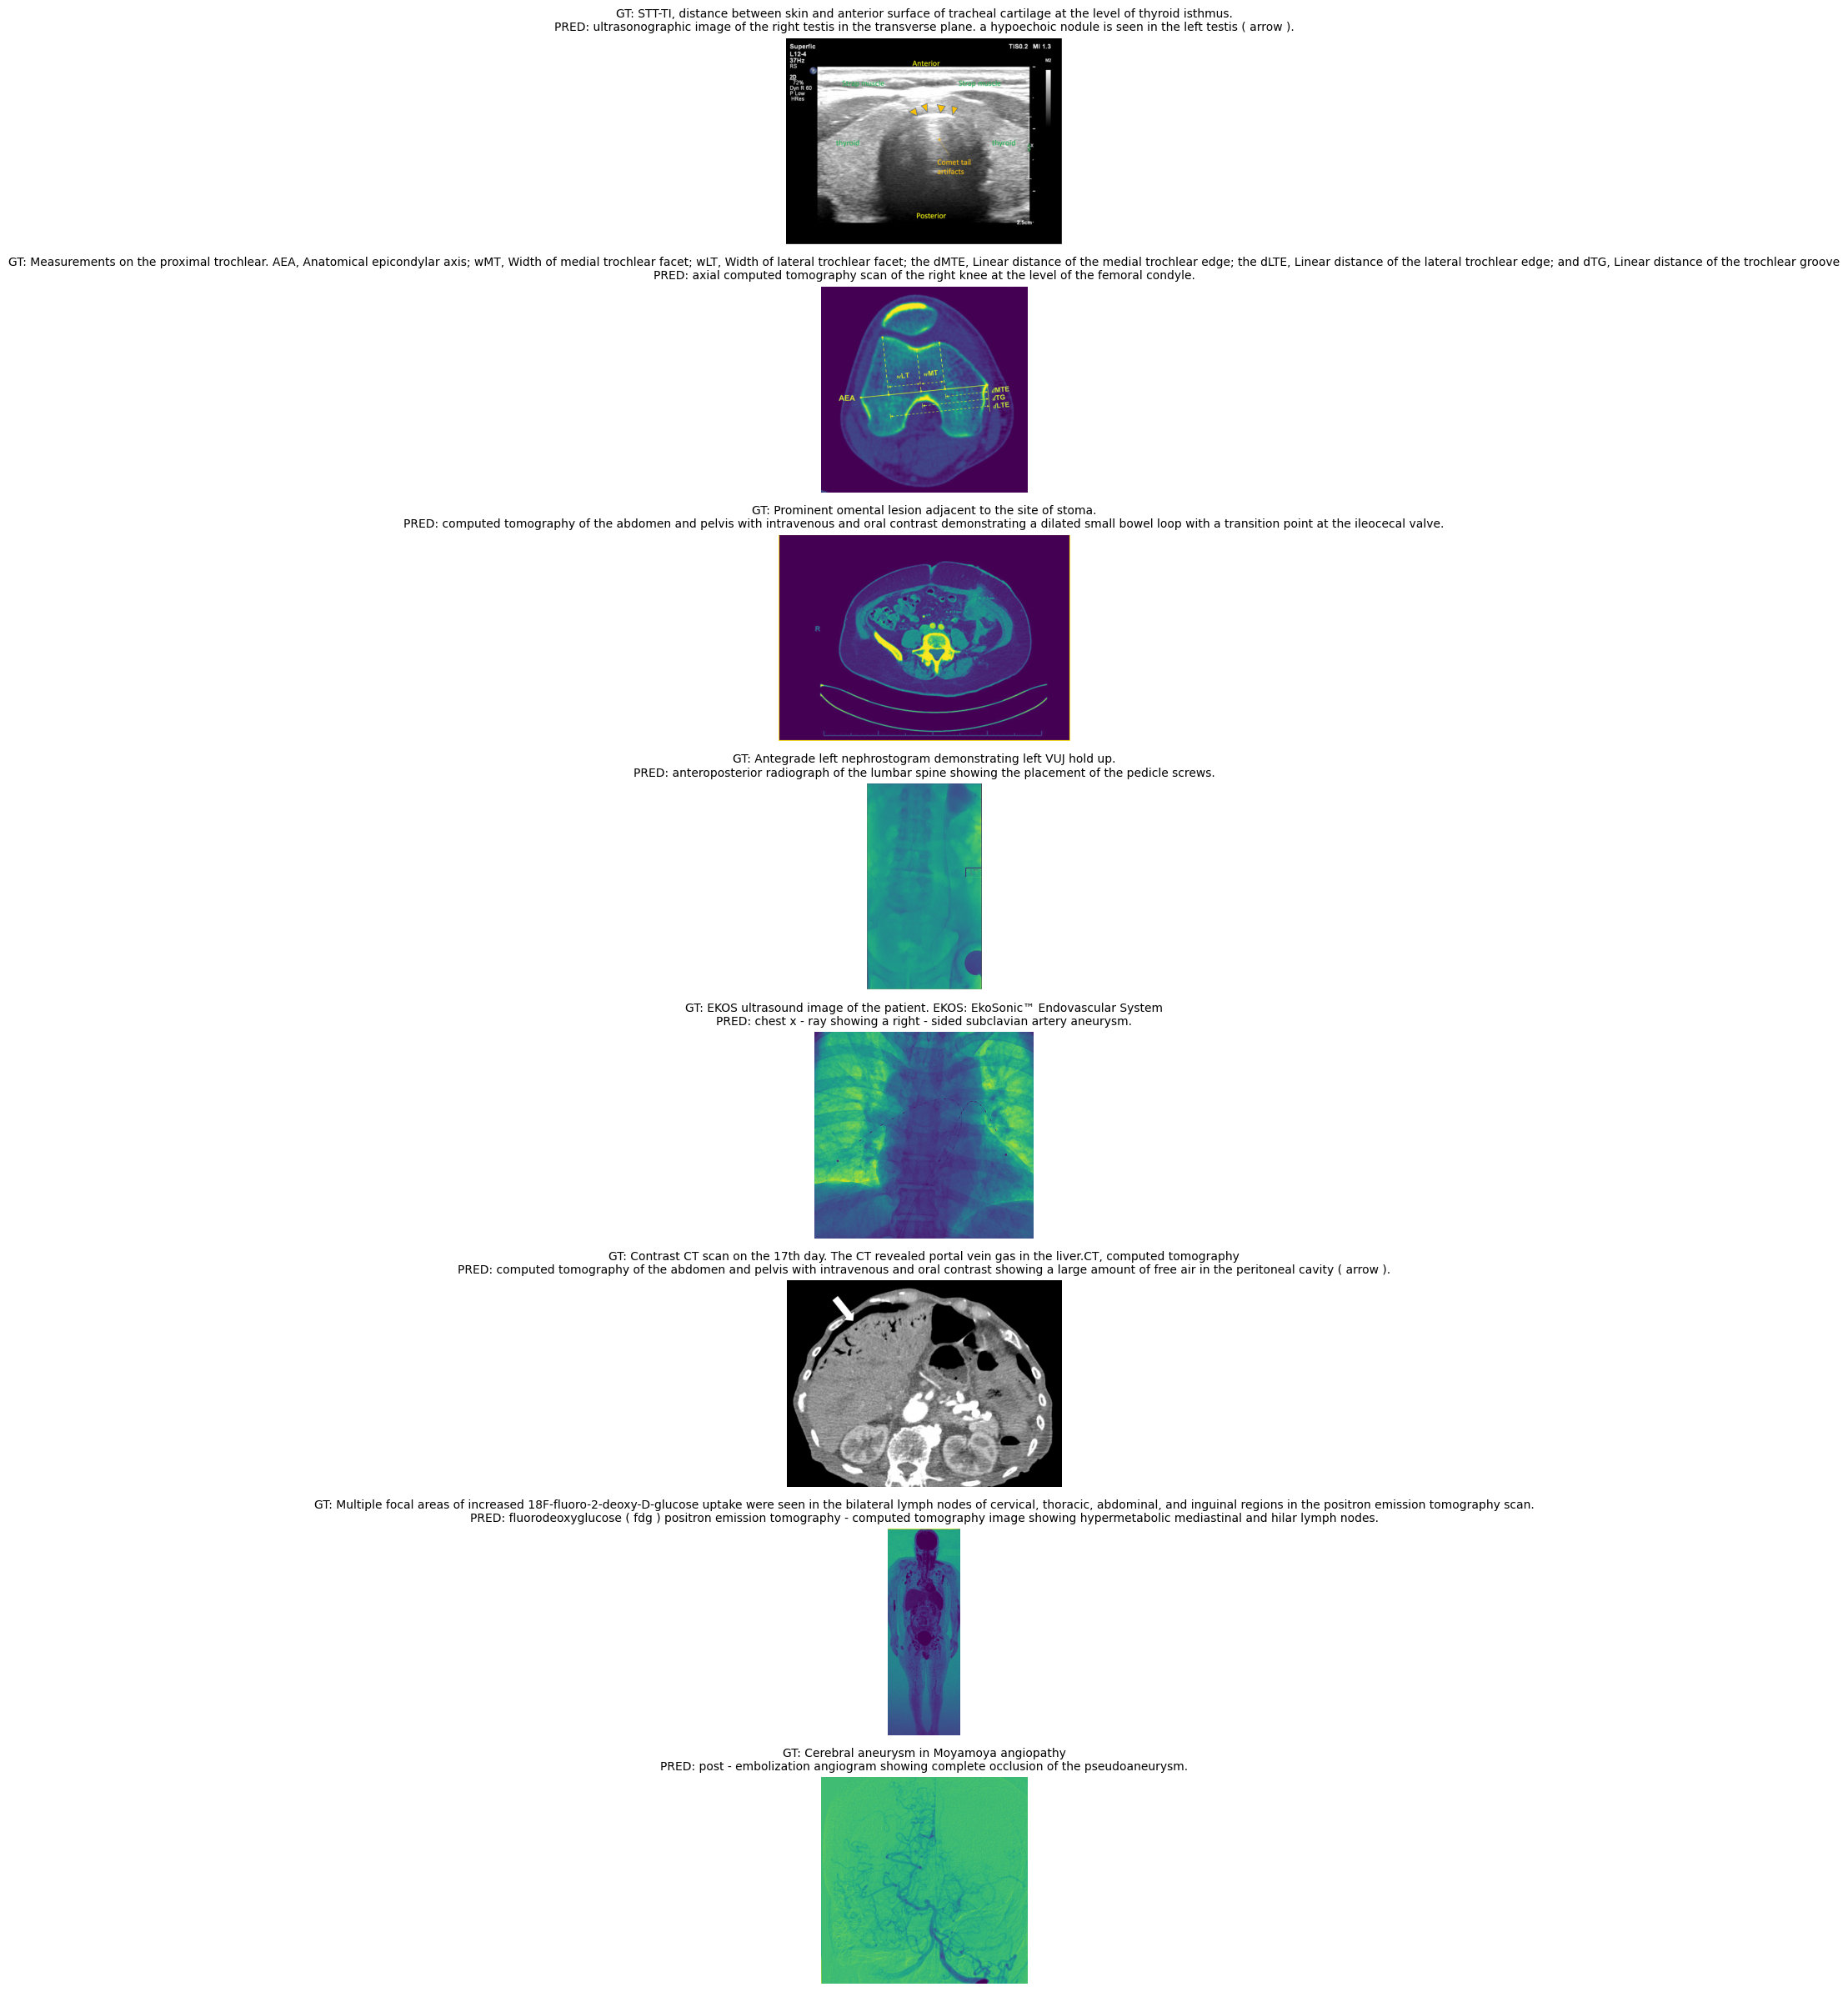

In [9]:
import random
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

ds = load_from_disk(cfg_data.data_dir)
ds_test = ds["test"]
def show_examples(ds_test, n=8, seed=42):
    rng = random.Random(seed)
    idxs = rng.sample(range(len(ds_test)), n)

    plt.figure(figsize=(12, 3*n))
    for i, idx in enumerate(idxs, start=1):
        ex = ds_test[idx]
        image = ex["image"]          # PIL.Image
        gt = ex["caption"]

        # preprocess + generate
        inputs = model.processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            gen_ids = model.model.generate(
                **inputs,
                max_new_tokens=160,
                num_beams=3,
                no_repeat_ngram_size=3,    
                repetition_penalty=1.15,    
                length_penalty=1.0,
            )
        pred = model.processor.tokenizer.decode(gen_ids[0], skip_special_tokens=True).strip()

        # plot
        ax = plt.subplot(n, 1, i)
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"GT: {gt}\nPRED: {pred}", fontsize=10)

    plt.tight_layout()
    plt.show()

show_examples(ds["test"], n=8)
